In [1]:
import numpy as np
from scipy.stats import norm
from scipy.special import expit
import matplotlib.pyplot as plt
from IPython.display import HTML
from itertools import product
import matplotlib.animation
from CellModels import Grid_BF
from Drawing import trajectory, line, upsample
from Visualization import plot_borders

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
def animate_(T, s, n, intvl):
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(s[0], origin='lower')

    frames = np.arange(0, T, intvl)

    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    def ani_f(i):
        ims = []
        im.set_data(s[i])
        im.autoscale()
        return [im]

    fig.tight_layout()

    # blit = True : only redraw the changed parts
    ani = matplotlib.animation.FuncAnimation(fig, ani_f, frames=frames, blit=True)
    
    return ani
#     HTML(ani.to_jshtml())

In [3]:
# l = []
# l.append(line([0, 0], [0, 2], num=50) - 1)
# l.append(line([0, 2], [1, 2], num=50) - 1)
# l.append(line([1, 2], [2, 2], num=50) - 1)
# l.append(line([2, 2], [2, 0], num=50) - 1)
# l.append(line([2, 0], [0, 0], num=50) - 1)
# l.append(line([1, 1], [1, 2], num=50) - 1)

# T = 3000
# # Trajectory
# x, v, hd = trajectory(np.pi/3, 0.1, T, l, [-0.5, 0])
# v = upsample(v, 100)
# s = g(alpha=1, T=v.shape[0], v=v, s_init=s_init, print_param=False)[0]

In [4]:
def connections(x, width, spread, excitation, scale):
    radial = np.exp(-(x / width)**2 / spread)
    period = (np.cos(np.pi * x / width) - 1 + excitation)
    return scale * radial * period

In [23]:
class Grid_BF_V2:
    def __init__(self, n, m, tau, l, width, spread, excitation, scale, 
                 periodic=True, print_param=True):
        ''' Modified version of 2D CANN grid cell model by Burak & Fiete (2009)

        Parameters
        ----------
        n : int
            Number of neurons along either side of the square sheet of grid cells
        m : int
            Number of preferred directions along either side of a square subregion
        tau : float
            Time constant, > 1
        l : float
            Shift amount of the DoG center
        scale : float, optional
            Scale of the weights
        periodic : bool, optional
            Periodic network (True) or aperiodic network (False)
        print_param : bool, optional
        '''
        self.N, self.M = n * n, m * m
        self.n, self.m = n, m
        self.tau = tau
        self.l = l

        self.periodic = periodic

        if print_param:
            print('n = %d' % n,
            'm = %d' % m,
            'tau = %.2f' % tau,
            'l = %.2f' % l,
            'a = %.2f' % a,
            'lam = %.2f' % lam,
            'c0 = %.2f' % c0,
            'beta_e = %.2f' % self.beta_e,
            'beta_i = %.2f' % self.beta_i,
            'c1 = %.2f' % c1,
            'periodic %s' % periodic, sep='\n')

        # preferred directions
        self.theta = np.linspace(0, 2 * np.pi, num=self.M, endpoint=False).reshape((m, m))
        e = np.zeros((n, n))
        for i in range(n//m):
            for j in range(n//m):
                e[i*m:(i+1)*m, j*m:(j+1)*m] = self.theta
        # unit vector corresponding to the directions
        self.e = np.stack((np.cos(e), np.sin(e)), axis=-1).reshape((self.N, 2))

        # Neuron locations
        _ = np.linspace(-n/2, n/2, num=n, endpoint=False)
        self.x = np.stack(np.meshgrid(_, _), axis=2).reshape((self.N, 2))

        # Calculate distances
        loc = self.x - l * self.e
        diff = np.abs(loc[:, None, :] - self.x[None, ...])
        
        if not periodic:
            dist = np.linalg.norm(diff, axis=-1)
        else:
            diff[diff > n/2] = n - diff[diff > n/2]
            dist = np.linalg.norm(diff, axis=-1)
            
        self.W = connections(dist, width, spread, excitation, scale)

    def __call__(self, alpha, T, v, hd,
                 R=None, dr=None, a0=20,
                 s_init=None, print_param=True):
        '''
        Parameters
        ----------
        alpha : float
            Velocity input scale
        T : int
            Simulation length
        v : np.ndarray
            Velocity input, with shape (T, 2)
        R : float, optional
            Radius of mask that passes input
        dr : float, optional
            Radius of mask that passes input completely
        a0 : float, optional
            Width of edge fading of the mask
        s_init : np.ndarray, optional
            Initial neuron state
        print_param : bool, optional

        Returns
        -------
        s : np.ndarray
            An array of shape (T, n, n) storing the neuron states over time
        '''

        if R is None:
            R = self.n
        if dr is None:
            dr = R

        if print_param:
            print('alpha = %.2f' % alpha,
                  'T = %d' % T,
                  'R = %d' % R,
                  'dr = %d' % dr,
                  'a0 = %.2f' % a0, sep='\n')

        s = np.zeros((T, self.N))
        # Init states
        if s_init is None: 
            s[0] = 0
            decay = 1
        else:
            s[0] = s_init.flatten()
            decay = 0

        # Calculate external input
        b = np.zeros(self.N)
        
        # Cos wave grating according to head direction
        cos_hd = np.cos(hd)
        sin_hd = np.sin(hd)
        rot_ = np.array([[cos_hd, -sin_hd], 
                        [sin_hd, cos_hd]])
        rot = np.moveaxis(rot_, -1, 0)

        _ = np.linspace(-np.pi*4, np.pi*4, num=self.n, endpoint=False)
        x_ = np.stack(np.meshgrid(_, _), axis=0).reshape(2, self.N)
        x = rot @ x_
        rot_mask = np.cos(x[:, 1, :]) #/ 2 + 0.5
        
        for t in range(1, T):
            decay = 2 if hd[t] != hd[t-1] or s_init is None else decay * 0.8
            b = 1 + alpha * self.e @ v[t-1]
            b += rot_mask[t] * decay
            input_mask = 1 if self.periodic else A(self.x, R, dr, self.periodic, a0)
            b *= input_mask
            
            p = s[t-1]
            
            for t_i in range(int(self.tau * 2 + decay * 10)):
                p_aux = self.W @ p + b # Aux
                p_aux[p_aux < 0] = 0 # ReLU

                pmax = p_aux.max()
                if pmax > 0:
                    p_aux /= pmax

                ds = -p + p_aux
                p += ds / self.tau
                p[p < 1e-9] = 0 # Avoid Numerical Error

            s[t] = p

        s = s.reshape((T, self.n, self.n))

        return s

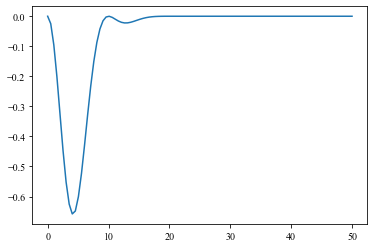

In [24]:
x = np.linspace(0, 50, num=100)
y = connections(x, width=5, spread=2, excitation=0, scale=0.5)

plt.plot(x, y)

In [27]:
T0 = 100
g = Grid_BF_V2(n=30, m=2, l=0.7, width=5, spread=4, excitation=0.5, scale=0.5, tau=4,
            print_param=False)
hd = np.zeros(T0)
s = g(alpha=0, T=T0, hd=hd, v=np.zeros((T0, 2)), print_param=False)

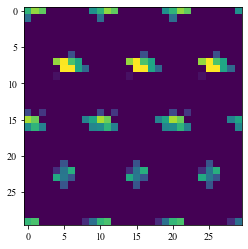

In [28]:
s_init = s[-1]
plt.imshow(s_init)
# HTML(animate_(3000, s, 30).to_jshtml())

In [29]:
T = 1500
v = np.zeros((T, 2))
hd = np.zeros(T)
deg = np.pi / 24
# hd[100:120] = deg * 1
# hd[120:140] = deg * 2
# hd[140:160] = deg * 3
# hd[160:180] = deg * 4
# hd[180:200] = deg * 5
# hd[200:220] = deg * 6
# hd[220:240] = deg * 7
# hd[240:260] = deg * 8
v[:, 1] = 1
s = g(alpha=0.5, T=T, hd=hd, v=v, print_param=False, s_init=s_init)

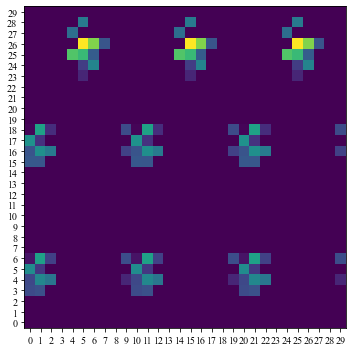

In [30]:
HTML(animate_(250, s[50:300], 30, 1).to_jshtml())

1. Incorrect motion direction during and shortly after the rotation period
2. Accuracy of rotation
3. 3D implementation

In [16]:
np.array([[np.pi*3/4, np.pi/4], [np.pi*5/4, np.pi*7/4]])

array([[2.35619449, 0.78539816],
       [3.92699082, 5.49778714]])

In [ ]:
class Grid_BF_V3:
    def __init__(self, n, m, tau, l, width, spread, excitation, scale, 
                 periodic=True, print_param=True):
        ''' Modified version of 2D CANN grid cell model by Burak & Fiete (2009)

        Parameters
        ----------
        n : int
            Number of neurons along either side of the square sheet of grid cells
        m : int
            Number of preferred directions along either side of a square subregion
        tau : float
            Time constant, > 1
        l : float
            Shift amount of the DoG center
        scale : float, optional
            Scale of the weights
        periodic : bool, optional
            Periodic network (True) or aperiodic network (False)
        print_param : bool, optional
        '''
        self.N, self.M = n * n, m * m
        self.n, self.m = n, m
        self.tau = tau
        self.l = l

        self.periodic = periodic

        if print_param:
            print('n = %d' % n,
            'm = %d' % m,
            'tau = %.2f' % tau,
            'l = %.2f' % l,
            'a = %.2f' % a,
            'lam = %.2f' % lam,
            'c0 = %.2f' % c0,
            'beta_e = %.2f' % self.beta_e,
            'beta_i = %.2f' % self.beta_i,
            'c1 = %.2f' % c1,
            'periodic %s' % periodic, sep='\n')

        # preferred directions
        self.theta = np.linspace(0, 2 * np.pi, num=self.M, endpoint=False).reshape((m, m))
        e = np.zeros((n, n))
        for i in range(n//m):
            for j in range(n//m):
                e[i*m:(i+1)*m, j*m:(j+1)*m] = self.theta
        # unit vector corresponding to the directions
        self.e = np.stack((np.cos(e), np.sin(e)), axis=-1).reshape((self.N, 2))

        # Neuron locations
        _ = np.linspace(-n/2, n/2, num=n, endpoint=False)
        self.x = np.stack(np.meshgrid(_, _), axis=2).reshape((self.N, 2))

        # Calculate distances
        loc = self.x - l * self.e
        diff = np.abs(loc[:, None, :] - self.x[None, ...])
        
        if not periodic:
            dist = np.linalg.norm(diff, axis=-1)
        else:
            diff[diff > n/2] = n - diff[diff > n/2]
            dist = np.linalg.norm(diff, axis=-1)
            
        self.W = connections(dist, width, spread, excitation, scale)

    def __call__(self, alpha, T, v, hd,
                 R=None, dr=None, a0=20,
                 s_init=None, print_param=True):
        '''
        Parameters
        ----------
        alpha : float
            Velocity input scale
        T : int
            Simulation length
        v : np.ndarray
            Velocity input, with shape (T, 2)
        R : float, optional
            Radius of mask that passes input
        dr : float, optional
            Radius of mask that passes input completely
        a0 : float, optional
            Width of edge fading of the mask
        s_init : np.ndarray, optional
            Initial neuron state
        print_param : bool, optional

        Returns
        -------
        s : np.ndarray
            An array of shape (T, n, n) storing the neuron states over time
        '''

        if R is None:
            R = self.n
        if dr is None:
            dr = R

        if print_param:
            print('alpha = %.2f' % alpha,
                  'T = %d' % T,
                  'R = %d' % R,
                  'dr = %d' % dr,
                  'a0 = %.2f' % a0, sep='\n')

        s = np.zeros((T, self.N))
        # Init states
        if s_init is None: 
            s[0] = 0
            decay = 1
        else:
            s[0] = s_init.flatten()
            decay = 0

        # Calculate external input
        b = np.zeros(self.N)
        
        # Cos wave grating according to head direction
        cos_hd = np.cos(hd)
        sin_hd = np.sin(hd)
        rot_ = np.array([[cos_hd, -sin_hd], 
                        [sin_hd, cos_hd]])
        rot = np.moveaxis(rot_, -1, 0)
        
        for t in range(1, T):
            b = 1 + alpha * self.e @ rot[t-1] @ v[t-1]
            input_mask = 1 if self.periodic else A(self.x, R, dr, self.periodic, a0)
            b *= input_mask
            
            p = s[t-1]
            
            for t_i in range(int(self.tau * 2 + decay * 10)):
                p_aux = self.W @ p + b # Aux
                p_aux[p_aux < 0] = 0 # ReLU

                pmax = p_aux.max()
                if pmax > 0:
                    p_aux /= pmax

                ds = -p + p_aux
                p += ds / self.tau
                p[p < 1e-9] = 0 # Avoid Numerical Error

            s[t] = p

        s = s.reshape((T, self.n, self.n))

        return s

In [ ]:
x = np.linspace(0, 50, num=100)
y = connections(x, width=5, spread=2, excitation=0, scale=0.5)

plt.plot(x, y)

In [ ]:
T0 = 100
g = Grid_BF_V3(n=30, m=2, l=0.7, width=5, spread=4, excitation=0.5, scale=0.5, tau=4,
            print_param=False)
hd = np.zeros(T0)
s = g(alpha=0, T=T0, hd=hd, v=np.zeros((T0-1, 2)), print_param=False)

In [ ]:
s_init = s[-1]
plt.imshow(s_init)
# HTML(animate_(3000, s, 30).to_jshtml())

In [ ]:
T = 1500
v = np.zeros((T-1, 2))
hd = np.linspace(0, np.pi * 4, num=T)
v[:, 1] = 1
s = g(alpha=0.5, T=T, hd=hd, v=v, print_param=False, s_init=s_init)

In [ ]:
m = 2
s_conj = np.zeros((T, n//m, n//m))
for i in range(n//m):
    for j in range(n//m):
        s_conj[:, i, j] = s[:, i*m:(i+1)*m, j*m:(j+1)*m].mean(axis=(1, 2))

In [ ]:
HTML(animate_(T, s_conj, 15, 10).to_jshtml())

## CANN for 3D HD